In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange
from multiprocess import Process
from threading import Thread
from sklearn.datasets import make_classification

## Importation of data

Le data provient du repo suivant : https://github.com/chentianyi1991/LAG-code s

In [2]:
# data = np.loadtxt("data/data2/data.txt")
# data.shape

In [3]:
# y = np.loadtxt("data/data2/y.txt", dtype=int)
# y.shape

In [4]:
data, y = make_classification(n_samples=10_000, n_features=40, n_redundant=0, n_informative=15)

In [5]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(scaled_data)
pca_data.shape

(10000, 2)

In [6]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,1.532515,-1.965726,1
1,-0.776982,-1.249565,0
2,1.739020,0.177122,1
3,0.948884,0.000472,1
4,1.186296,0.277842,0
...,...,...,...
9995,0.944472,-2.002606,0
9996,-0.576060,-0.822002,0
9997,-0.117280,-0.888372,0
9998,-0.151264,0.297775,1


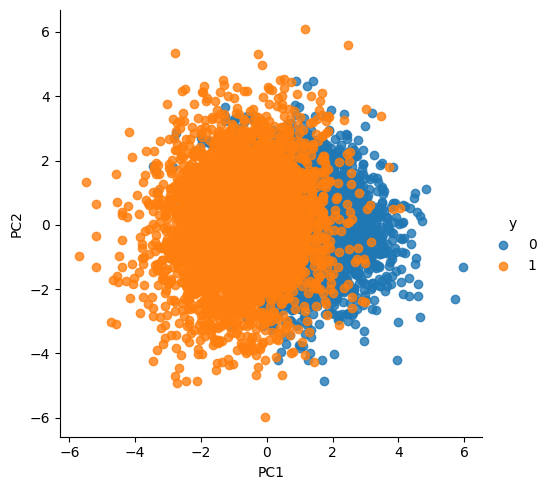

In [7]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [8]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = scaled_data
data = temp_data
data.shape

(10000, 41)

In [9]:
d = data.shape[1]
d

41

## Logistic Regression

In [10]:
rho = 1

In [11]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.8511

In [12]:
opt_theta = clf.coef_
opt_theta

array([[-0.15148032, -0.03517608,  0.59263278,  0.02905777,  0.02606405,
         1.05557468, -0.75806381,  0.37379846,  0.01058352, -0.04797878,
         0.02793112,  0.09511258, -0.44298373,  0.00493369, -0.01323619,
        -0.03130423, -0.02351972,  0.04233565, -0.00569811, -0.30332413,
        -0.00490185, -0.01037372,  0.00508954,  0.22860222,  0.00362515,
        -1.17348264, -0.46993761, -0.03690336, -0.71107523, -0.26935662,
        -0.01256923, -0.01845634, -0.01553935,  0.04818057, -0.05250649,
         0.31464085, -0.13040196, -0.82127891,  0.01558079, -0.00995727,
        -0.05540006]])

In [13]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.3602527681512093

## GADMM not parallelized

In [14]:
K = 200  # number of iterations
M = 4 # number of workers
rho = 1

split_data = np.array_split(data, M)

In [15]:
len(split_data)

4

In [16]:
split_data[0].shape

(2500, 41)

In [17]:
split_y = np.array_split(y, M)

In [18]:
len(split_y)

4

In [19]:
split_y[0].shape

(2500,)

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:
def f(theta, sample_data, sample_y):
    proba_pred = [
        sigmoid(np.inner(theta, sample_data[i])) for i in range(len(sample_y))
    ]
    # y_pred = [int(proba>0.5) for proba in proba_pred]

    return log_loss(sample_y, proba_pred, labels=[0, 1])

In [22]:
f(opt_theta, data, y)

0.3602527681512093

On a la même loss qu'avec sklearn, tout va bien !

---



In [23]:
def objective_function(
    theta_n,
    sample_data,
    sample_y,
    lamb_n,
    lamb_n_minus_1,
    theta_n_minus_1,
    theta_n_plus_1,
    rho,
):
    resul = f(theta_n, sample_data, sample_y)
    if theta_n_minus_1 is not None:
        resul += lamb_n_minus_1 @ (theta_n_minus_1 - theta_n)
        resul += (rho / 2) * ((theta_n_minus_1 - theta_n) ** 2).sum()
    if theta_n_plus_1 is not None:
        resul += lamb_n @ (theta_n - theta_n_plus_1)
        resul += (rho / 2) * ((theta_n - theta_n_plus_1) ** 2).sum()

    return resul

In [24]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

for k in trange(K):
    # Step 1 : head workers
    for n in range(M):
        if n % 2 == 0:
            sample_data = split_data[n]
            sample_y = split_y[n]
            lamb_n = Lamb[n]
            lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
            theta_n_minus_1 = Theta[n - 1] if n > 0 else None
            theta_n_plus_1 = Theta[n + 1] if n < M else None
            res = minimize(
                objective_function,
                x0=Theta[n],
                args=(
                    sample_data,
                    sample_y,
                    lamb_n,
                    lamb_n_minus_1,
                    theta_n_minus_1,
                    theta_n_plus_1,
                    rho,
                ),
            )
            Theta[n] = res.x

    # Step 2 : tail workers
    for n in range(M):
        if n % 2 == 1:
            sample_data = split_data[n]
            sample_y = split_y[n]
            lamb_n = Lamb[n]
            lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
            theta_n_minus_1 = Theta[n - 1] if n > 0 else None
            theta_n_plus_1 = Theta[n + 1] if n < M - 1 else None
            res = minimize(
                objective_function,
                x0=Theta[n],
                args=(
                    sample_data,
                    sample_y,
                    lamb_n,
                    lamb_n_minus_1,
                    theta_n_minus_1,
                    theta_n_plus_1,
                    rho,
                ),
            )
            Theta[n] = res.x

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

  0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
Theta[0]

array([-0.13142038, -0.03805623,  0.40270675, -1.42112445, -0.8849508 ,
       -0.00665132, -0.64018035,  0.04043383,  0.00988685,  0.00639541,
       -0.00152717, -0.02365522,  0.0465868 ,  0.02136728,  0.04705628,
        0.50372156,  0.00451908, -0.02072782, -0.04858216,  0.41511213,
        0.01266513, -0.01752611,  0.73326091, -0.02500187,  0.02845226,
        0.06916153,  0.34181551, -0.11294426, -0.01649096, -0.26025861,
        0.00821507, -0.76294826,  0.00428637, -0.58139653, -0.01501491,
        0.02402477,  0.02079489,  0.82681223, -0.00987409, -0.01349217,
        0.01408371])

In [24]:
def display_df_log(df_log):
    sns.lineplot(x="iteration", y="theta diff norm", data=df_log, hue="worker")
    plt.grid()
    plt.show()

    sns.lineplot(x="iteration", y="loss", data=df_log, hue="worker")
    plt.grid()
    plt.show()

    df_data = []
    for n in range(M):
        df_data.append(
            {
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )
    display(pd.DataFrame(df_data))

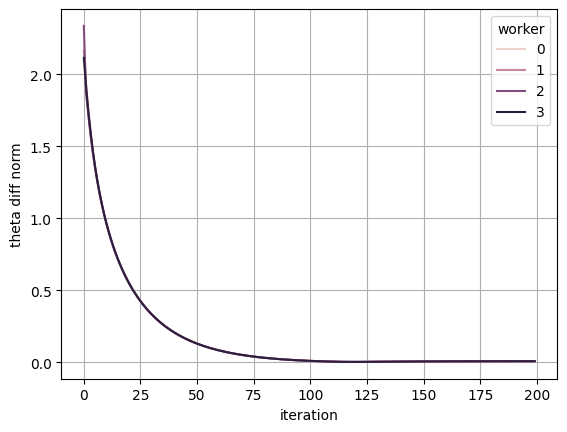

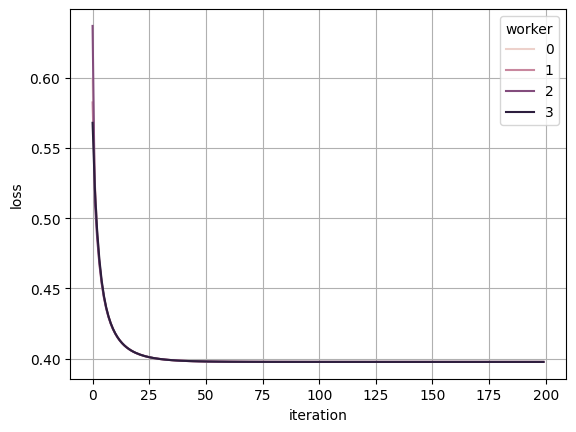

,worker,theta diff norm,loss
0,0,0.006752,0.397613
1,1,0.006749,0.397613
2,2,0.006747,0.397613
3,3,0.006769,0.397613


In [27]:
display_df_log(df_log)

In [25]:
# Multithreading

def thread_func_head(sample_data, sample_y, Lamb, Theta, n):
    lamb_n = Lamb[n]
    lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
    theta_n_minus_1 = Theta[n - 1] if n > 0 else None
    theta_n_plus_1 = Theta[n + 1] if n < M else None
    res = minimize(
        objective_function,
        x0=Theta[n],
        args=(
            sample_data,
            sample_y,
            lamb_n,
            lamb_n_minus_1,
            theta_n_minus_1,
            theta_n_plus_1,
            rho,
        ),
    )
    Theta[n] = res.x


def thread_func_tail(sample_data, sample_y, Lamb, Theta, n):
    lamb_n = Lamb[n]
    lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
    theta_n_minus_1 = Theta[n - 1] if n > 0 else None
    theta_n_plus_1 = Theta[n + 1] if n < M - 1 else None
    res = minimize(
        objective_function,
        x0=Theta[n],
        args=(
            sample_data,
            sample_y,
            lamb_n,
            lamb_n_minus_1,
            theta_n_minus_1,
            theta_n_plus_1,
            rho,
        ),
    )
    Theta[n] = res.x

In [30]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

for k in trange(K):
    # Step 1 : head workers
    threads = []
    for n in range(M):
        if n % 2 == 0:
            thread = Thread(target=thread_func_head, args=(split_data[n], split_y[n], Lamb, Theta, n))
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 2 : tail workers
    threads = []
    for n in range(M):
        if n % 2 == 1:
            thread = Thread(target=thread_func_tail, args=(split_data[n], split_y[n], Lamb, Theta, n))
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

  0%|          | 0/200 [00:00<?, ?it/s]

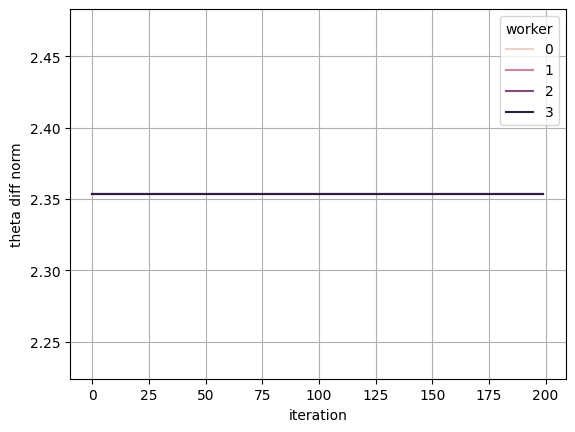

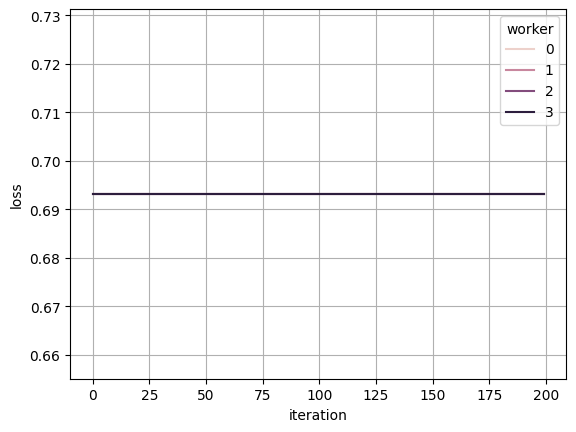

,worker,theta diff norm,loss
0,0,2.353548,0.693147
1,1,2.353548,0.693147
2,2,2.353548,0.693147
3,3,2.353548,0.693147


In [27]:
display_df_log(df_log)